In [49]:
log_path = "/Users/armaan/Desktop/imc-prosperity-quant-nyc/submissions/2024-04-22_02-29-13.log"

In [50]:
import re
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from scipy.stats import kurtosis, normaltest, skew


def read_file_sections(filepath):
    section_delimiters = ["Sandbox logs:", "Activities log:", "Trade History:"]
    current_section = None
    data = {key: [] for key in section_delimiters}

    with open(filepath, "r") as file:
        for line in file:
            line = line.strip()
            if line in section_delimiters:
                current_section = line
                continue
            if current_section:
                data[current_section].append(line)

    return data


def extract_trades(text):
    # Regex to find all blocks enclosed in curly braces
    trade_pattern = r"\{[^{}]*\}"
    # Regex to extract key-value pairs within curly braces
    kv_pattern = r"\"(\w+)\":\s*(\"[^\"]*\"|\d+)"

    trades = []
    matches = re.findall(trade_pattern, text)
    for match in matches:
        trade_data = {}
        for key, value in re.findall(kv_pattern, match):
            if value.startswith('"') and value.endswith('"'):
                value = value.strip('"')
            else:
                value = int(value)
            trade_data[key] = value
        trades.append(trade_data)
    return trades


sections = read_file_sections(log_path)
activities_data = "\n".join(sections["Activities log:"])
activities_df = pd.read_csv(StringIO(activities_data), delimiter=";")
trade_history_text = "\n".join(sections["Trade History:"])
trades = extract_trades(trade_history_text)
trade_history_df = pd.DataFrame(trades)

In [51]:
# Selecting the required columns
df = activities_df[["timestamp", "product", "mid_price", "profit_and_loss"]]

# Pivot the DataFrame to normalize it by timestamp with multiple values
normalized_df = df.pivot_table(
    index="timestamp",
    columns="product",
    values=["mid_price", "profit_and_loss"],
    aggfunc='mean'
).reset_index()

# Flatten the MultiIndex in columns and rename appropriately
normalized_df.columns = [
    f"{col[1].lower()}_{col[0]}" if col[1] else col[0] for col in normalized_df.columns
]

# Calculate the arbitrage basket midprice
normalized_df["arbitrage_basket_midprice"] = (
    4 * normalized_df["chocolate_mid_price"] +
    6 * normalized_df["strawberries_mid_price"] +
    1 * normalized_df["roses_mid_price"]
)


# Example to view the DataFrame
normalized_df.tail()


,timestamp,amethysts_mid_price,chocolate_mid_price,coconut_mid_price,coconut_coupon_mid_price,gift_basket_mid_price,orchids_mid_price,roses_mid_price,starfruit_mid_price,strawberries_mid_price,amethysts_profit_and_loss,chocolate_profit_and_loss,coconut_profit_and_loss,coconut_coupon_profit_and_loss,gift_basket_profit_and_loss,orchids_profit_and_loss,roses_profit_and_loss,starfruit_profit_and_loss,strawberries_profit_and_loss,arbitrage_basket_midprice
995,99500,10003.5,7765.5,9961.0,597.5,69429.5,1057.0,14263.5,4981.0,3966.5,1661.0,1413.375,0.0,6530.148438,11152.75,-41.802246,0.0,1483.128906,0.0,69124.5
996,99600,10002.0,7766.5,9960.5,596.5,69435.5,1058.0,14262.5,4982.0,3966.0,1663.0,1124.375,0.0,6673.867188,11491.25,-41.802246,0.0,1483.591797,0.0,69124.5
997,99700,10000.0,7765.5,9962.5,595.5,69434.5,1058.0,14265.5,4980.5,3966.0,1663.0,1414.375,0.0,6769.914062,11447.50,-41.802246,0.0,1480.000000,0.0,69123.5
998,99800,10001.0,7765.5,9963.5,597.5,69438.5,1057.0,14266.5,4980.0,3966.0,1663.0,1381.625,0.0,6520.273438,11696.00,-41.802246,0.0,1480.000000,0.0,69124.5
999,99900,10001.0,7767.0,9962.0,597.5,69445.5,1056.0,14264.5,4980.0,3967.5,1663.0,1044.375,0.0,6456.140625,12107.50,-41.802246,0.0,1480.000000,0.0,69137.5


Columns with constant values (will be dropped from correlation matrix): ['coconut_profit_and_loss', 'roses_profit_and_loss', 'strawberries_profit_and_loss']


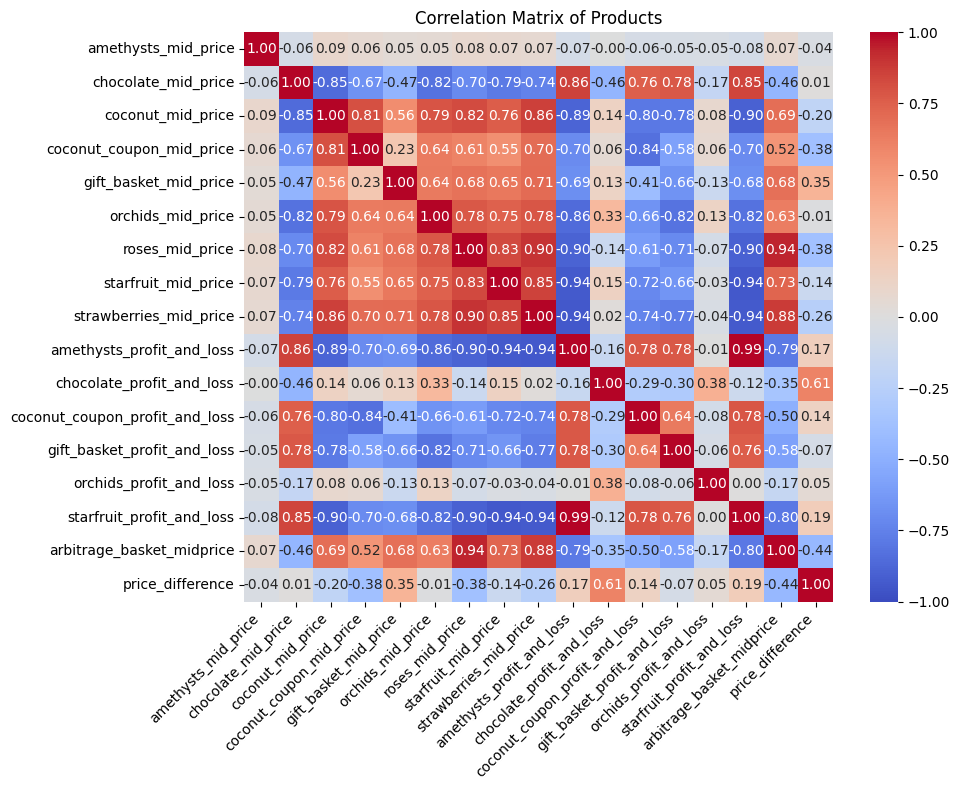

In [54]:

normalized_df["price_difference"] = (
    normalized_df["gift_basket_mid_price"] - normalized_df["arbitrage_basket_midprice"]
)


normalized_df_corrs = normalized_df.drop(columns=["timestamp"])

constant_columns = normalized_df_corrs.columns[normalized_df_corrs.nunique() <= 1]
if len(constant_columns) > 0:
    print(
        f"Columns with constant values (will be dropped from correlation matrix): {constant_columns.tolist()}"
    )
    normalized_df_corrs.drop(columns=constant_columns, inplace=True)

correlation_matrix = normalized_df_corrs.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    vmin=-1,
    vmax=1,
    center=0,
)
plt.title("Correlation Matrix of Products")
plt.xticks(rotation=45, ha="right")  # Rotate x labels for better readability
plt.yticks(rotation=0)  # Ensure y labels are horizontal for readability
plt.tight_layout()  # Adjust layout to make room for label rotations
plt.show()

In [55]:
trade_history_df

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,,SUBMISSION,STARFRUIT,SEASHELLS,5002,1
1,0,,SUBMISSION,STARFRUIT,SEASHELLS,5001,19
2,0,,,STRAWBERRIES,SEASHELLS,3984,10
3,100,SUBMISSION,,AMETHYSTS,SEASHELLS,9998,1
4,200,,,COCONUT,SEASHELLS,9990,6
...,...,...,...,...,...,...,...
1769,99800,SUBMISSION,,COCONUT_COUPON,SEASHELLS,598,16
1770,99800,SUBMISSION,,COCONUT_COUPON,SEASHELLS,598,14
1771,99800,SUBMISSION,,COCONUT_COUPON,SEASHELLS,598,2
1772,99900,,,COCONUT,SEASHELLS,9961,7


In [56]:
trade_history_df["signed_quantity"] = trade_history_df.apply(
    lambda row: (
        row["quantity"]
        if row["buyer"] == "SUBMISSION"
        else -row["quantity"] if row["seller"] == "SUBMISSION" else 0
    ),
    axis=1,
)


pivot_df = trade_history_df.pivot_table(
    index="timestamp",
    columns="symbol",
    values="signed_quantity",
    aggfunc = "sum"
)

pivot_df.columns = [f"{col}_trades_made" for col in pivot_df.columns]
pivot_df.fillna(0, inplace=True)
pivot_df = pivot_df.astype(int)
pivot_df.reset_index(inplace=True)
merged_df = pd.merge(normalized_df, pivot_df, on="timestamp")

In [57]:
pd.set_option('display.max_columns', None)
merged_df


,timestamp,amethysts_mid_price,chocolate_mid_price,coconut_mid_price,coconut_coupon_mid_price,gift_basket_mid_price,orchids_mid_price,roses_mid_price,starfruit_mid_price,strawberries_mid_price,amethysts_profit_and_loss,chocolate_profit_and_loss,coconut_profit_and_loss,coconut_coupon_profit_and_loss,gift_basket_profit_and_loss,orchids_profit_and_loss,roses_profit_and_loss,starfruit_profit_and_loss,strawberries_profit_and_loss,arbitrage_basket_midprice,price_difference,AMETHYSTS_trades_made,CHOCOLATE_trades_made,COCONUT_trades_made,COCONUT_COUPON_trades_made,GIFT_BASKET_trades_made,ORCHIDS_trades_made,ROSES_trades_made,STARFRUIT_trades_made,STRAWBERRIES_trades_made
0,0,10000.0,7751.0,9991.0,620.0,69553.5,1094.5,14415.5,5005.0,3985.0,0.0,0.0000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,69329.5,224.0,0,0,0,0,0,0,0,-20,0
1,100,9997.0,7751.5,9990.0,620.5,69556.0,1095.0,14418.5,5004.5,3985.0,0.0,0.0000,0.0,0.000000,0.00,0.000000,0.0,-66.281250,0.0,69334.5,221.5,1,0,0,0,0,0,0,0,0
2,200,10000.0,7751.5,9990.5,620.5,69563.0,1092.0,14421.0,5004.5,3985.0,2.0,0.0000,0.0,0.000000,0.00,0.000000,0.0,-62.117188,0.0,69337.0,226.0,0,0,0,0,0,0,0,0,0
3,300,10000.0,7750.5,9991.5,621.5,69551.5,1094.0,14423.0,5005.0,3984.5,2.0,0.0000,0.0,0.000000,0.00,0.000000,0.0,-77.500000,0.0,69332.0,219.5,0,119,0,0,41,0,0,0,0
4,400,10000.0,7749.5,9990.0,621.5,69547.5,1094.0,14426.0,5006.5,3985.0,2.0,-235.4375,0.0,0.000000,-458.75,0.000000,0.0,-57.031250,0.0,69334.0,213.5,0,0,0,-36,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,99500,10003.5,7765.5,9961.0,597.5,69429.5,1057.0,14263.5,4981.0,3966.5,1661.0,1413.3750,0.0,6530.148438,11152.75,-41.802246,0.0,1483.128906,0.0,69124.5,305.0,-1,0,0,0,0,0,0,0,0
767,99600,10002.0,7766.5,9960.5,596.5,69435.5,1058.0,14262.5,4982.0,3966.0,1663.0,1124.3750,0.0,6673.867188,11491.25,-41.802246,0.0,1483.591797,0.0,69124.5,311.0,-4,0,0,0,0,0,0,-4,0
768,99700,10000.0,7765.5,9962.5,595.5,69434.5,1058.0,14265.5,4980.5,3966.0,1663.0,1414.3750,0.0,6769.914062,11447.50,-41.802246,0.0,1480.000000,0.0,69123.5,311.0,0,0,0,46,0,0,0,0,0
769,99800,10001.0,7765.5,9963.5,597.5,69438.5,1057.0,14266.5,4980.0,3966.0,1663.0,1381.6250,0.0,6520.273438,11696.00,-41.802246,0.0,1480.000000,0.0,69124.5,314.0,0,0,0,32,0,0,0,0,0


# GIFT BASKET

In [58]:
import plotly.graph_objects as go

for pin in ["price_difference", "gift_basket_mid_price"]:
    # Plot for the price difference, standard deviation, and trades
    fig_diff = go.Figure()

    # Add the line plot for price difference on the primary y-axis
    fig_diff.add_trace(
        go.Scatter(
            x=merged_df["timestamp"],
            y=merged_df[f"{pin}"],
            mode="lines+markers",
            name=f"{pin.upper()}",
            line=dict(color="blue"),
            marker=dict(symbol="circle", size=4),
        )
    )

    # Standard deviation areas
    mean_difference = merged_df[f"{pin}"].mean()
    std_deviation = merged_df[f"{pin}"].std()

    fig_diff.add_hline(
        y=mean_difference, line_dash="dash", line_color="red", annotation_text="Mean"
    )
    fig_diff.add_hline(
        y=mean_difference + std_deviation,
        line_dash="dash",
        line_color="green",
        annotation_text="+1 Std Dev",
    )
    fig_diff.add_hline(
        y=mean_difference - std_deviation,
        line_dash="dash",
        line_color="green",
        annotation_text="-1 Std Dev",
    )
    fig_diff.add_hline(
        y=mean_difference + 2 * std_deviation,
        line_dash="dash",
        line_color="purple",
        annotation_text="+2 Std Dev",
    )
    fig_diff.add_hline(
        y=mean_difference - 2 * std_deviation,
        line_dash="dash",
        line_color="purple",
        annotation_text="-2 Std Dev",
    )

    # Trades for Gift Basket
    trades = merged_df[merged_df["GIFT_BASKET_trades_made"] != 0]
    buys = trades[trades["GIFT_BASKET_trades_made"] > 0]
    sells = trades[trades["GIFT_BASKET_trades_made"] < 0]

    # Buys and Sells on the primary y-axis
    fig_diff.add_trace(
        go.Scatter(
            x=buys["timestamp"],
            y=buys[f"{pin}"],
            mode="markers",
            name=f"{pin.upper()}: BUYS",
            marker=dict(symbol="triangle-up", size=18, color="green"),
            text=[f"QTY:{qty}" for qty in buys["GIFT_BASKET_trades_made"]],
            hoverinfo="text+x+y",
        )
    )
    fig_diff.add_trace(
        go.Scatter(
            x=sells["timestamp"],
            y=sells[f"{pin}"],
            mode="markers",
            name=f"{pin.upper():}: SELLS",
            marker=dict(symbol="triangle-down", size=18, color="red"),
            text=[f"QTY:{qty}" for qty in sells["GIFT_BASKET_trades_made"]],
            hoverinfo="text+x+y",
        )
    )

    fig_diff.update_layout(
        title=f"{pin.upper()} with Standard Deviation and Trades",
        xaxis_title="Timestamp",
        yaxis_title=f"{pin.upper()}",
        legend_title="Legend",
        height=600,
        width=1000,
    )

    fig_diff.show()

---

# OTHER PRODUCTS

In [59]:
import plotly.graph_objects as go

# List of products excluding Gift Basket
other_products = [
    "AMETHYSTS",
    "CHOCOLATE",
    "ORCHIDS",
    "ROSES",
    "STARFRUIT",
    "STRAWBERRIES",
]

for product in other_products:
    fig = go.Figure()

    # Add the line plot for mid_price of the product
    fig.add_trace(
        go.Scatter(
            x=merged_df["timestamp"],
            y=merged_df[f"{product.lower()}_mid_price"],
            mode="lines",
            name=f"{product} Mid Price",
            line=dict(color="blue"),
        )
    )

    # Filter for non-zero trades to mark for this product
    trades = merged_df[merged_df[f"{product}_trades_made"] != 0]
    buys = trades[trades[f"{product}_trades_made"] > 0]
    sells = trades[trades[f"{product}_trades_made"] < 0]

    # Buys
    fig.add_trace(
        go.Scatter(
            x=buys["timestamp"],
            y=buys[f"{product.lower()}_mid_price"],
            mode="markers",
            name="Buys",
            marker=dict(symbol="triangle-up", size=12, color="green"),
            text=[f"{qty} trades" for qty in buys[f"{product}_trades_made"]],
            hoverinfo="text+x+y",
        )
    )

    # Sells
    fig.add_trace(
        go.Scatter(
            x=sells["timestamp"],
            y=sells[f"{product.lower()}_mid_price"],
            mode="markers",
            name="Sells",
            marker=dict(symbol="triangle-down", size=12, color="red"),
            text=[f"{-qty} trades" for qty in sells[f"{product}_trades_made"]],
            hoverinfo="text+x+y",
        )
    )

    fig.update_layout(
        title=f"{product} Mid Price and Trade Activity Over Time",
        xaxis_title="Timestamp",
        yaxis_title=f"{product} Mid Price",
        legend_title="Legend",
        height=600,
        width=1000,
    )

    fig.show()

In [14]:
merged_df

,timestamp,amethysts_mid_price,chocolate_mid_price,gift_basket_mid_price,orchids_mid_price,roses_mid_price,starfruit_mid_price,strawberries_mid_price,amethysts_profit_and_loss,chocolate_profit_and_loss,gift_basket_profit_and_loss,orchids_profit_and_loss,roses_profit_and_loss,starfruit_profit_and_loss,strawberries_profit_and_loss,arbitrage_basket_midprice,price_difference,AMETHYSTS_trades_made,CHOCOLATE_trades_made,GIFT_BASKET_trades_made,ORCHIDS_trades_made,ROSES_trades_made,STARFRUIT_trades_made,STRAWBERRIES_trades_made
0,0,10000.0,7889.0,70598.5,1056.0,14421.5,5026.0,4036.5,0.0,0.000,0.00,0.00000,0.0000,0.000000,0.0000,70196.5,402.0,0,0,0,0,0,-20,0
1,100,9997.0,7889.5,70615.5,1054.5,14424.0,5028.0,4036.5,0.0,0.000,0.00,0.00000,0.0000,-73.125000,0.0000,70201.0,414.5,1,0,0,0,0,0,0
2,200,10000.0,7890.5,70617.5,1054.5,14422.5,5024.5,4037.0,2.0,0.000,0.00,0.00000,0.0000,-58.281250,0.0000,70206.5,411.0,0,0,0,0,0,0,0
3,300,10000.0,7890.0,70615.5,1055.5,14421.5,5025.5,4037.0,2.0,0.000,0.00,0.00000,0.0000,-68.328125,0.0000,70203.5,412.0,0,0,0,0,0,0,0
4,400,10000.0,7890.0,70629.5,1056.5,14422.0,5025.0,4037.0,2.0,0.000,0.00,0.00000,0.0000,-58.171875,0.0000,70204.0,425.5,0,0,-40,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,99300,10000.0,7896.0,70707.5,1047.5,14404.0,5014.5,4044.5,1478.0,8032.750,27509.25,10437.90625,1444.7500,1105.640625,-906.2500,70255.0,452.5,0,0,0,-100,0,-7,0
694,99400,10000.0,7896.0,70706.5,1048.5,14403.5,5013.0,4044.0,1478.0,8018.625,27567.00,10427.90625,1447.0625,1122.890625,-767.1250,70251.5,455.0,0,0,0,-100,0,0,0
695,99500,10001.5,7897.5,70708.5,1048.0,14402.0,5013.5,4043.5,1478.0,7739.375,27475.25,10517.90625,1528.8750,1129.867188,-642.3125,70253.0,455.5,0,0,0,0,0,0,0
696,99700,10000.0,7898.0,70719.5,1051.5,14402.5,5010.5,4043.5,1478.0,7654.750,26797.25,10517.90625,1518.0625,1126.500000,-693.1250,70255.5,464.0,0,0,0,0,0,1,0


In [1]:
import pandas as pd

df = merged_df
df["bundle_mid_price"] = (
    4 * df["chocolate_mid_price"]
    + 6 * df["strawberries_mid_price"]
    + 1 * df["roses_mid_price"]
)

df["premium"] = df["gift_basket_mid_price"] - df["bundle_mid_price"]

window_size = (
    1000  # This is the number of entries to include in the rolling calculation
)

df["rolling_mean"] = df["premium"].rolling(window=window_size, min_periods=4).mean()
df["rolling_std"] = df["premium"].rolling(window=window_size, min_periods=4).std()

df["zscore"] = (df["premium"] - df["rolling_mean"]) / df["rolling_std"]

df["zscore"].fillna(
    0, inplace=True
) 

gift_basket_df = df

NameError: name 'merged_df' is not defined

In [45]:
df

,timestamp,amethysts_mid_price,chocolate_mid_price,gift_basket_mid_price,orchids_mid_price,roses_mid_price,starfruit_mid_price,strawberries_mid_price,amethysts_profit_and_loss,chocolate_profit_and_loss,gift_basket_profit_and_loss,orchids_profit_and_loss,roses_profit_and_loss,starfruit_profit_and_loss,strawberries_profit_and_loss,arbitrage_basket_midprice,price_difference,AMETHYSTS_trades_made,CHOCOLATE_trades_made,GIFT_BASKET_trades_made,ORCHIDS_trades_made,ROSES_trades_made,STARFRUIT_trades_made,STRAWBERRIES_trades_made,bundle_mid_price,premium,rolling_mean,rolling_std,zscore
0,0,10000.0,7889.0,70598.5,1056.0,14421.5,5026.0,4036.5,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,70196.5,402.0,0,0,0,0,0,-20,0,70196.5,402.0,NaN,NaN,0.000000
1,100,9997.0,7889.5,70615.5,1054.5,14424.0,5028.0,4036.5,0.0,0.0,0.0,0.00000,0.0,-73.125000,0.0,70201.0,414.5,1,0,0,0,0,0,0,70201.0,414.5,NaN,NaN,0.000000
2,200,10000.0,7890.5,70617.5,1054.5,14422.5,5024.5,4037.0,2.0,0.0,0.0,0.00000,0.0,-58.281250,0.0,70206.5,411.0,0,0,0,0,0,0,0,70206.5,411.0,NaN,NaN,0.000000
3,300,10000.0,7890.0,70615.5,1055.5,14421.5,5025.5,4037.0,2.0,0.0,0.0,0.00000,0.0,-68.328125,0.0,70203.5,412.0,0,0,0,0,0,0,0,70203.5,412.0,NaN,NaN,0.000000
4,400,10000.0,7890.0,70629.5,1056.5,14422.0,5025.0,4037.0,2.0,0.0,0.0,0.00000,0.0,-58.171875,0.0,70204.0,425.5,0,0,-40,0,0,0,0,70204.0,425.5,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,99300,10000.0,7896.0,70707.5,1047.5,14404.0,5014.5,4044.5,1478.0,0.0,29221.0,10437.90625,0.0,1105.640625,0.0,70255.0,452.5,0,0,0,-100,0,-7,0,70255.0,452.5,412.828928,33.820913,1.172975
681,99400,10000.0,7896.0,70706.5,1048.5,14403.5,5013.0,4044.0,1478.0,0.0,29279.5,10427.90625,0.0,1122.890625,0.0,70251.5,455.0,0,0,0,-100,0,0,0,70251.5,455.0,412.890762,33.834629,1.244560
682,99500,10001.5,7897.5,70708.5,1048.0,14402.0,5013.5,4043.5,1478.0,0.0,29186.0,10517.90625,0.0,1129.867188,0.0,70253.0,455.5,0,0,0,0,0,0,0,70253.0,455.5,412.953148,33.849102,1.256957
683,99700,10000.0,7898.0,70719.5,1051.5,14402.5,5010.5,4043.5,1478.0,0.0,28496.5,10517.90625,0.0,1126.500000,0.0,70255.5,464.0,0,0,0,0,0,1,0,70255.5,464.0,413.027778,33.880582,1.504467


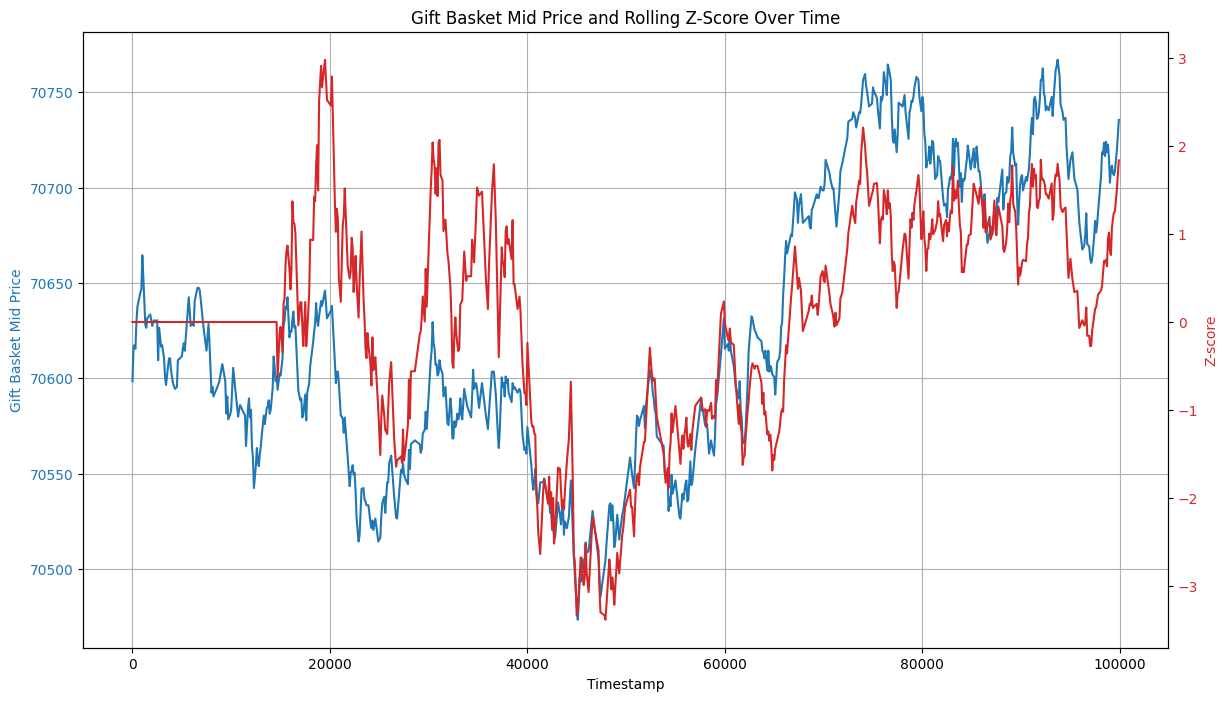

In [46]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:blue'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Gift Basket Mid Price', color=color)
ax1.plot(gift_basket_df['timestamp'], gift_basket_df['gift_basket_mid_price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Z-score', color=color)  # we already handled the x-label with ax1
ax2.plot(gift_basket_df['timestamp'], gift_basket_df['zscore'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Gift Basket Mid Price and Rolling Z-Score Over Time')
ax1.grid(True)

plt.show()


In [33]:
df

,timestamp,product,mid_price,profit_and_loss
0,0,ORCHIDS,1094.5,0.000000
1,0,CHOCOLATE,7751.0,0.000000
2,0,GIFT_BASKET,69553.5,0.000000
3,0,AMETHYSTS,10000.0,0.000000
4,0,STARFRUIT,5005.0,0.000000
...,...,...,...,...
8995,99900,STARFRUIT,4980.0,1480.000000
8996,99900,GIFT_BASKET,69445.5,9243.500000
8997,99900,COCONUT_COUPON,597.5,0.000000
8998,99900,ORCHIDS,1056.0,-41.802246
